<a href="https://colab.research.google.com/github/taka7peace/Ramain_derivery_analysis/blob/main/Ramain_delivery3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Ramain Delivery 3

I will create a simple model building system to examine and evaluate models from multiple perspectives.

Once the model is built, a simplified forecasting system is created to accommodate updated data. 

I will also incorporate the data analysis system to create a small-scale system that can withstand updated data

#Predicting New Data with the Machine Learning Model

to complete the flow of new data forecasting, new data forecasting will be performed using the March 2020 order data as the new data.

In [ ]:
import os
data_dir = 'data'
input_dir = os.path.join(data_dir, '0_input')
output_dir = os.path.join(data_dir, '1_output')
master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'
os.makedirs(input_dir,exist_ok=True)
os.makedirs(output_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

In [ ]:
import pandas as pd
m_area_file = 'm_area.csv'
m_store_file = 'm_store.csv'
m_area = pd.read_csv(os.path.join(master_dir, m_area_file), encoding='utf-8')
m_store = pd.read_csv(os.path.join(master_dir, m_store_file), encoding='utf-8')

In [ ]:
tg_ym = "202003"
target_file = "tbl_order_" + tg_ym + ".csv"
target_data = pd.read_csv(os.path.join(input_dir, target_file), encoding='utf-8')

import datetime
max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")
if tg_ym == min_str_date and tg_ym == max_str_date:
    print("Date Match")
else:
    raise Exception("Date does not Match")

Date Match


In [ ]:
def calc_delta(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/60

def data_processing(order_data):
    order_data = order_data.loc[order_data['store_id'] != 999]
    order_data = pd.merge(order_data, m_store, on='store_id', how='left')
    order_data = pd.merge(order_data, m_area, on='area_cd', how='left')
    order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'Delivery'
    order_data.loc[order_data['takeout_flag'] == 1, 'takeout_name'] = 'Take Out'
    order_data.loc[order_data['status'] == 0, 'status_name'] = 'Reception'
    order_data.loc[order_data['status'] == 1, 'status_name'] = 'Payment Completed'
    order_data.loc[order_data['status'] == 2, 'status_name'] = 'Delivered'
    order_data.loc[order_data['status'] == 9, 'status_name'] = 'Cancelation'
    
    order_data.loc[:,'order_accept_datetime'] = pd.to_datetime(order_data['order_accept_date'])
    order_data.loc[:,'delivered_datetime'] = pd.to_datetime(order_data['delivered_date'])
    order_data.loc[:,'delta'] = order_data[['order_accept_datetime', 'delivered_datetime']].apply(calc_delta, axis=1)
    order_data.loc[:,'order_accept_hour'] = order_data['order_accept_datetime'].dt.hour
    order_data.loc[:,'order_accept_weekday'] = order_data['order_accept_datetime'].dt.weekday
    order_data.loc[order_data['order_accept_weekday'] >= 5, 'weekday_info'] = 'Weekend'
    order_data.loc[order_data['order_accept_weekday'] < 5, 'weekday_info'] = 'Weekday'
    
    store_data = order_data.groupby(['store_name']).count()[['order_id']]
    store_f = order_data.loc[(order_data['status_name']=="Delivered")|
                             (order_data['status_name']=="Payment Completed")].groupby(['store_name']).count()[['order_id']]
    store_c = order_data.loc[order_data['status_name']=="Cancelation"].groupby(['store_name']).count()[['order_id']]
    store_d = order_data.loc[order_data['takeout_name']=="Delivery"].groupby(['store_name']).count()[['order_id']]
    store_t = order_data.loc[order_data['takeout_name']=="Take Out"].groupby(['store_name']).count()[['order_id']]
    store_weekday = order_data.loc[order_data['weekday_info']=="Weekday"].groupby(['store_name']).count()[['order_id']]
    store_weekend = order_data.loc[order_data['weekday_info']=="Weekend"].groupby(['store_name']).count()[['order_id']]
    times = order_data['order_accept_hour'].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[order_data['order_accept_hour']==time].groupby(['store_name']).count()[['order_id']]
        time_tmp.columns = [f'order_time_{time}']
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)
    store_delta = order_data.loc[order_data['status_name']!="Cancelation"].groupby(['store_name']).mean(numeric_only=True)[['delta']]
    store_data.columns = ['order']
    store_f.columns = ['order_fin']
    store_c.columns = ['order_cancel']
    store_d.columns = ['order_delivery']
    store_t.columns = ['order_takeout']
    store_delta.columns = ['delta_avg']
    store_weekday.columns = ['order_weekday']
    store_weekend.columns = ['order_weekend']
    store_data = pd.concat([store_data, store_f, store_c, store_d, store_t, 
                        store_weekday, store_weekend, store_time, store_delta], axis=1)


    return store_data

In [ ]:
store_data = data_processing(target_data)
store_data.reset_index(drop=False, inplace=True)
actual_data = store_data.copy()

##Let's deal with categorical variables of new data.


##Aggregate the new data by store

In [ ]:
category_data = pd.get_dummies(store_data['store_name'], prefix='store' ,prefix_sep='_')
del category_data['store_麻生店']
store_data = pd.concat([store_data, category_data],axis=1)
store_data.head(3)

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,あきる野店,1186,958,228,858,328,839,347,104,107,...,0,0,0,0,0,0,0,0,0,0
1,さいたま南店,1553,1266,287,1145,408,1103,450,165,136,...,0,0,0,0,0,0,0,0,0,0
2,さいたま緑店,1063,875,188,807,256,754,309,113,82,...,0,0,0,0,0,0,0,0,0,0


##Let's prepare the data in the format just before putting them into the model.


In [ ]:
X_cols_name = 'X_cols1.csv'
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name), encoding='utf-8')
X_cols = X_cols['X_cols']


In [ ]:
X = store_data[X_cols].copy()
X.head(3)

,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,order_time_13,...,store_駒沢店,store_駒込店,store_高円寺店,store_高島平店,store_高崎店,store_高座店,store_高津店,store_高田馬場店,store_鴻巣店,store_鶴見店
0,1186,958,228,858,328,839,347,104,107,109,...,0,0,0,0,0,0,0,0,0,0
1,1553,1266,287,1145,408,1103,450,165,136,140,...,0,0,0,0,0,0,0,0,0,0
2,1063,875,188,807,256,754,309,113,82,79,...,0,0,0,0,0,0,0,0,0,0


##Let's read the model file


In [ ]:
import pickle
model_weekday_name = "model_y_weekday_GradientBoosting.pickle"
model_weekend_name = "model_y_weekend_GradientBoosting.pickle"

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode='rb') as f:
    model_weekday = pickle.load(f)
    
with open(model_weekend_path, mode='rb') as f:
    model_weekend = pickle.load(f)
    
print(model_weekday)
print(model_weekend)


GradientBoostingClassifier(random_state=0)
GradientBoostingClassifier(random_state=0)


##Let's try to forecast new data


In [ ]:
pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)
pred_weekend[:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.])

In [ ]:
pred_proba_weekday = model_weekday.predict_proba(X)
pred_proba_weekend = model_weekend.predict_proba(X)
pred_proba_weekend[:10]

array([[0.80064464, 0.19935536],
       [0.87201729, 0.12798271],
       [0.58953939, 0.41046061],
       [0.81264039, 0.18735961],
       [0.7953738 , 0.2046262 ],
       [0.81505971, 0.18494029],
       [0.80016372, 0.19983628],
       [0.73176139, 0.26823861],
       [0.43888391, 0.56111609],
       [0.89325379, 0.10674621]])

In [ ]:
pred_proba_weekday = pred_proba_weekday[:,1]
pred_proba_weekend = pred_proba_weekend[:,1]
pred_proba_weekend[:10]

array([0.19935536, 0.12798271, 0.41046061, 0.18735961, 0.2046262 ,
       0.18494029, 0.19983628, 0.26823861, 0.56111609, 0.10674621])

In [ ]:
pred = pd.DataFrame({'pred_weekday':pred_weekday, 'pred_weekend':pred_weekend, 
                     'score_weekday':pred_proba_weekday, 'score_weekend':pred_proba_weekend})
pred.loc[:,'store_name'] = store_data['store_name']
pred.loc[:,'year_month'] = tg_ym
pred.head(3)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0,0.0,0.804468,0.199355,あきる野店,202003
1,0.0,0.0,0.413692,0.127983,さいたま南店,202003
2,1.0,0.0,0.886107,0.410461,さいたま緑店,202003


##Let's create a heatmap of the forecast results


In [ ]:
pred_viz = pred[['store_name','score_weekday','score_weekend']].copy()
pred_viz.set_index('store_name', inplace=True)
pred_viz

,score_weekday,score_weekend
store_name,,
あきる野店,0.804468,0.199355
さいたま南店,0.413692,0.127983
さいたま緑店,0.886107,0.410461
さいたま西店,0.525863,0.187360
つくば店,0.745303,0.204626
...,...,...
高津店,0.604720,0.258655
高田馬場店,0.777813,0.282977
鴻巣店,0.498269,0.270865


In [ ]:
pip install japanize_matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


<Axes: xlabel='store_name'>

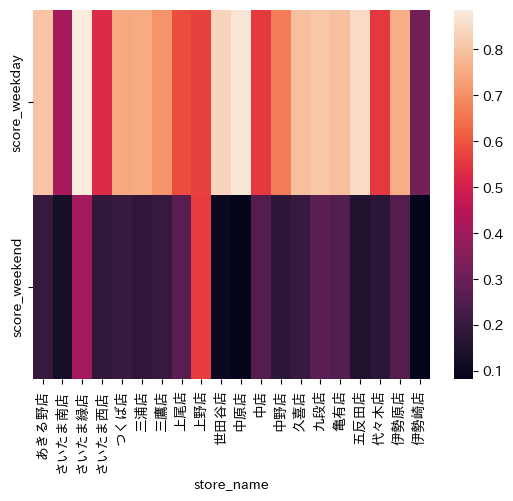

In [ ]:
import seaborn as sns
import japanize_matplotlib
japanize_matplotlib.japanize()
sns.heatmap(pred_viz[:20].T)

##Let's create actual data


In [ ]:
target_cols = ['store_name', 'order', 'order_fin', 'order_cancel', 'order_delivery',
       'order_takeout', 'order_weekday', 'order_weekend', 'delta_avg']
actual_data = actual_data[target_cols]
actual_cols = ['store_name']
rename_cols = [x + f'_{tg_ym}' for x in actual_data.columns if x != 'store_name']
actual_cols.extend(rename_cols)
actual_data.columns = actual_cols
actual_data.head(3)

,store_name,order_202003,order_fin_202003,order_cancel_202003,order_delivery_202003,order_takeout_202003,order_weekday_202003,order_weekend_202003,delta_avg_202003
0,あきる野店,1186,958,228,858,328,839,347,35.204593
1,さいたま南店,1553,1266,287,1145,408,1103,450,35.259084
2,さいたま緑店,1063,875,188,807,256,754,309,35.268571


##Let's create and output a report for the field

In [ ]:
pred.loc[pred['score_weekday'] >= 0.75,'Order_Prediction_Weekday'] = 'High Increase'
pred.loc[(pred['score_weekday'] < 0.75)&(pred['score_weekday'] >= 0.5),'Order_Prediction_Weekday'] = 'Increase'
pred.loc[(pred['score_weekday'] < 0.5)&(pred['score_weekday'] >= 0.25),'Order_Prediction_Weekday'] = 'Decrease'
pred.loc[pred['score_weekday'] < 0.25,'Order_Prediction_Weekday'] = 'High Decrease'

pred.loc[pred['score_weekend'] >= 0.75,'Order_Prediction_Weekend'] = 'High Increase'
pred.loc[(pred['score_weekend'] < 0.75)&(pred['score_weekend'] >= 0.5),'Order_Prediction_Weekend'] = 'Increase'
pred.loc[(pred['score_weekend'] < 0.5)&(pred['score_weekend'] >= 0.25),'Order_Prediction_Weekend'] = 'Decrease'
pred.loc[pred['score_weekend'] < 0.25,'Order_Prediction_Weekend'] = 'High Decrease'


In [ ]:
report = pred[['store_name','Order_Prediction_Weekday','Order_Prediction_Weekend', 'score_weekday', 'score_weekend']]
report = pd.merge(report, store_data , on='store_name', how='left')


In [ ]:
pred_ym = datetime.datetime.strptime(tg_ym, '%Y%m')
from dateutil.relativedelta import relativedelta
pred_ym = pred_ym + relativedelta(months=1)
pred_ym = datetime.datetime.strftime(pred_ym, '%Y%m')

report_name = f'report_pred_{pred_ym}.xlsx'
report.to_excel(os.path.join(output_dir, report_name), index=False)

By building a series of flows from data processing to forecasting with the model, I have an image that can handle updated data.

#Create a small-scale machine learning system


Starting with data processing, I built a machine learning model and created a whole process from new data forecasting to reporting. While I are happy to have implemented a full set of functions, I are also aware of the fact that no data has been accumulated. I thought that data would be accumulated when updating the data, so that I could review the model and validate the new data forecast. Therefore,I would like to utilize the functionality I have created to accumulate data at the time of monthly updates and further build a monthly model based on the accumulated data.

In [ ]:
import os
import pandas as pd
data_dir = 'data'
store_monthly_dir = os.path.join(data_dir, '01_store_monthly')
ml_base_dir = os.path.join(data_dir, '02_ml_base')

output_ml_result_dir = os.path.join(data_dir, '10_output_ml_result')
output_report_dir = os.path.join(data_dir, '11_output_report')

store_monthly_file = 'store_monthly_data.csv'
ml_base_file = 'ml_base_data.csv'

store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file))
ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file))
display(store_monthly_data.head(3))
display(ml_base_data.head(3))

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,delta_avg,year_month,order_202004,order_fin_202004,order_cancel_202004,order_delivery_202004,order_takeout_202004,order_weekday_202004,order_weekend_202004,delta_avg_202004
0,あきる野店,1147.0,945.0,202.0,841.0,306.0,844.0,303.0,91.0,122.0,...,34.110053,201904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,さいたま南店,1504.0,1217.0,287.0,1105.0,399.0,1104.0,400.0,130.0,135.0,...,35.337716,201904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,さいたま緑店,1028.0,847.0,181.0,756.0,272.0,756.0,272.0,95.0,91.0,...,34.291617,201904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0,0.0,1147,945,202,841,306,844,303,...,101,95,107,106,100,108,109,96,34.110053,201904
1,さいたま南店,1.0,1.0,1504,1217,287,1105,399,1104,400,...,143,142,137,130,113,140,132,155,35.337716,201904
2,さいたま緑店,1.0,1.0,1028,847,181,756,272,756,272,...,95,102,82,90,93,95,95,84,34.291617,201904


In [ ]:
import os
data_dir = 'data'
input_dir = os.path.join(data_dir, '00_input')
store_monthly_dir = os.path.join(data_dir, '01_store_monthly')
ml_base_dir = os.path.join(data_dir, '02_ml_base')

output_ml_result_dir = os.path.join(data_dir, '10_output_ml_result')
output_report_dir = os.path.join(data_dir, '11_output_report')

master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'

os.makedirs(input_dir,exist_ok=True)
os.makedirs(store_monthly_dir,exist_ok=True)
os.makedirs(ml_base_dir,exist_ok=True)
os.makedirs(output_ml_result_dir,exist_ok=True)
os.makedirs(output_report_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

##Let's generate folders and define initial variables



In [ ]:
tg_ym = '202004'

target_file = "tbl_order_" + tg_ym + ".csv"
m_area_file = 'm_area.csv'
m_store_file = 'm_store.csv'
store_monthly_file = 'store_monthly_data.csv'
ml_base_file = 'ml_base_data.csv'

##Let's read updated data and create store-by-store data


In [ ]:
import pandas as pd
m_area = pd.read_csv(os.path.join(master_dir, m_area_file),encoding='utf-8')
m_store = pd.read_csv(os.path.join(master_dir, m_store_file),encoding='utf-8')
target_data = pd.read_csv(os.path.join(input_dir, target_file),encoding='utf-8')

import datetime
max_date = pd.to_datetime(target_data["order_accept_date"]).max()
min_date = pd.to_datetime(target_data["order_accept_date"]).min()
max_str_date = max_date.strftime("%Y%m")
min_str_date = min_date.strftime("%Y%m")
if tg_ym == min_str_date and tg_ym == max_str_date:
    print("Date Match")
else:
    raise Exception("Date does not Match")

Date Match


##Update Monthly Store Data


In [ ]:
def calc_delta(t):
    t1, t2 = t
    delta = t2 - t1
    return delta.total_seconds()/60

def data_processing(order_data):
    order_data = order_data.loc[order_data['store_id'] != 999]
    order_data = pd.merge(order_data, m_store, on='store_id', how='left')
    order_data = pd.merge(order_data, m_area, on='area_cd', how='left')
    order_data.loc[order_data['takeout_flag'] == 0, 'takeout_name'] = 'Delivery'
    order_data.loc[order_data['takeout_flag'] == 1, 'takeout_name'] = 'Take Out'
    order_data.loc[order_data['status'] == 0, 'status_name'] = 'Reception'
    order_data.loc[order_data['status'] == 1, 'status_name'] = 'Payment Completed'
    order_data.loc[order_data['status'] == 2, 'status_name'] = 'Delivered'
    order_data.loc[order_data['status'] == 9, 'status_name'] = 'Cancelation'
    
    order_data.loc[:,'order_accept_datetime'] = pd.to_datetime(order_data['order_accept_date'])
    order_data.loc[:,'delivered_datetime'] = pd.to_datetime(order_data['delivered_date'])
    order_data.loc[:,'delta'] = order_data[['order_accept_datetime', 'delivered_datetime']].apply(calc_delta, axis=1)
    order_data.loc[:,'order_accept_hour'] = order_data['order_accept_datetime'].dt.hour
    order_data.loc[:,'order_accept_weekday'] = order_data['order_accept_datetime'].dt.weekday
    order_data.loc[order_data['order_accept_weekday'] >= 5, 'weekday_info'] = 'Weekend'
    order_data.loc[order_data['order_accept_weekday'] < 5, 'weekday_info'] = 'Weekday'
    
    store_data = order_data.groupby(['store_name']).count()[['order_id']]
    store_f = order_data.loc[(order_data['status_name']=="Delivered")|
                             (order_data['status_name']=="Payment Completed")].groupby(['store_name']).count()[['order_id']]
    store_c = order_data.loc[order_data['status_name']=="Cancelation"].groupby(['store_name']).count()[['order_id']]
    store_d = order_data.loc[order_data['takeout_name']=="Delivery"].groupby(['store_name']).count()[['order_id']]
    store_t = order_data.loc[order_data['takeout_name']=="Take Out"].groupby(['store_name']).count()[['order_id']]
    store_weekday = order_data.loc[order_data['weekday_info']=="Weekday"].groupby(['store_name']).count()[['order_id']]
    store_weekend = order_data.loc[order_data['weekday_info']=="Weekend"].groupby(['store_name']).count()[['order_id']]
    times = order_data['order_accept_hour'].unique()
    store_time = []
    for time in times:
        time_tmp = order_data.loc[order_data['order_accept_hour']==time].groupby(['store_name']).count()[['order_id']]
        time_tmp.columns = [f'order_time_{time}']
        store_time.append(time_tmp)
    store_time = pd.concat(store_time, axis=1)
    store_delta = order_data.loc[order_data['status_name']!="Cancelation"].groupby(['store_name']).mean(numeric_only=True)[['delta']]
    store_data.columns = ['order']
    store_f.columns = ['order_fin']
    store_c.columns = ['order_cancel']
    store_d.columns = ['order_delivery']
    store_t.columns = ['order_takeout']
    store_delta.columns = ['delta_avg']
    store_weekday.columns = ['order_weekday']
    store_weekend.columns = ['order_weekend']
    store_data = pd.concat([store_data, store_f, store_c, store_d, store_t, 
                        store_weekday, store_weekend, store_time, store_delta], axis=1)


    return store_data

In [ ]:
store_data = data_processing(target_data)
store_data.reset_index(drop=False, inplace=True)
store_data.loc[:,'year_month'] = tg_ym
store_data.head(1)


,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1147,945,202,848,299,842,305,92,125,...,101,97,105,103,97,110,109,96,34.520635,202004


##Let's Create and Update Data for Machine Learning


In [ ]:
store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file), encoding='utf-8')
print(f'before update：{len(store_monthly_data)}')
store_monthly_data = pd.concat([store_monthly_data, store_data], ignore_index=True)
store_monthly_data.loc[:, 'year_month'] = store_monthly_data['year_month'].astype(str)
store_monthly_data.drop_duplicates(subset=['store_name','year_month'], inplace=True, keep='last')
print(f'after update：{len(store_monthly_data)}')
store_monthly_data.to_csv(os.path.join(store_monthly_dir, store_monthly_file), index=False)

before update：3315
after update：3315


In [ ]:
from dateutil.relativedelta import relativedelta
y = store_monthly_data[['store_name', 'year_month','order_weekday', 'order_weekend']].copy()
y.loc[:,'one_month_ago'] = pd.to_datetime(y['year_month'], format='%Y%m')
y.loc[:,'one_month_ago'] = y['one_month_ago'].map(lambda x: x - relativedelta(months=1))
y.loc[:,'one_month_ago'] = y['one_month_ago'].dt.strftime('%Y%m')

y_one_month_ago = y.copy()
y_one_month_ago.rename(columns={'order_weekday':'order_weekday_one_month_ago', 
                                'order_weekend':'order_weekend_one_month_ago',
                                'year_month':'year_month_for_join'}, inplace=True)

y = pd.merge(y, y_one_month_ago[['store_name', 'year_month_for_join', 
                                 'order_weekday_one_month_ago', 'order_weekend_one_month_ago']], 
                                 left_on=['store_name', 'one_month_ago'], 
                                 right_on=['store_name','year_month_for_join'], how='left')

y.dropna(inplace=True)
y.loc[y['order_weekday'] - y['order_weekday_one_month_ago'] > 0, 'y_weekday'] = 1
y.loc[y['order_weekday'] - y['order_weekday_one_month_ago'] <= 0, 'y_weekday'] = 0
y.loc[y['order_weekend'] - y['order_weekend_one_month_ago'] > 0, 'y_weekend'] = 1
y.loc[y['order_weekend'] - y['order_weekend_one_month_ago'] <= 0, 'y_weekend'] = 0

y.rename(columns={'year_month':'target_year_month'},inplace=True)
y = y[['store_name','target_year_month', 'one_month_ago', 'y_weekday', 'y_weekend']].copy()
ml_data = pd.merge(y, store_monthly_data, left_on=['store_name','one_month_ago'],
                   right_on=['store_name','year_month'], how='left')

del ml_data["target_year_month"]
del ml_data["one_month_ago"]
ml_data.head(3)

<ipython-input-37-20646793e0b1>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  y.loc[:,'one_month_ago'] = y['one_month_ago'].map(lambda x: x - relativedelta(months=1))


,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0,0.0,1147,945,202,841,306,844,303,...,101,95,107,106,100,108,109,96,34.110053,201904
1,さいたま南店,1.0,1.0,1504,1217,287,1105,399,1104,400,...,143,142,137,130,113,140,132,155,35.337716,201904
2,さいたま緑店,1.0,1.0,1028,847,181,756,272,756,272,...,95,102,82,90,93,95,95,84,34.291617,201904


In [ ]:
ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file), encoding='utf-8')
print(f'before：{len(ml_base_data)}counts')
ml_base_data = pd.concat([ml_base_data, ml_data], ignore_index=True)
ml_base_data.loc[:, 'year_month'] = ml_base_data['year_month'].astype(str)
ml_base_data.drop_duplicates(subset=['store_name','year_month'], inplace=True, keep='last')
print(f'after：{len(ml_base_data)}counts')
ml_base_data.to_csv(os.path.join(ml_base_dir, ml_base_file), index=False)

before：3120counts
after：3120counts


##Let's Process Preliminary Data for Machine Learning Model


In [ ]:
category_data = pd.get_dummies(ml_base_data['store_name'], prefix='store' ,prefix_sep='_')
del category_data['store_麻生店']
del ml_base_data['year_month']
del ml_base_data['store_name']
ml_base_data = pd.concat([ml_base_data, category_data],axis=1)

from sklearn.model_selection import train_test_split
train_data, test_data = train_test_split(ml_base_data, test_size=0.3, random_state=0)
print(f'Train：{len(train_data)}/ Test:{len(test_data)}')
print(f'Weekday Train0：{len(train_data.loc[train_data["y_weekday"]==0])}')
print(f'Weekday Train1：{len(train_data.loc[train_data["y_weekday"]==1])}')
print(f'Weekday Test0：{len(test_data.loc[test_data["y_weekday"]==0])}')
print(f'Weekday Test1：{len(test_data.loc[test_data["y_weekday"]==1])}')

print(f'Weekend Train0：{len(train_data.loc[train_data["y_weekend"]==0])}')
print(f'Weekend Train1：{len(train_data.loc[train_data["y_weekend"]==1])}')
print(f'Weekend Test0：{len(test_data.loc[test_data["y_weekend"]==0])}')
print(f'Weekend Test1：{len(test_data.loc[test_data["y_weekend"]==1])}')

Train：2184/ Test:936
Weekday Train0：1022
Weekday Train1：1162
Weekday Test0：456
Weekday Test1：480
Weekend Train0：1045
Weekend Train1：1139
Weekend Test0：451
Weekend Test1：485


##Let's Build and Evaluate Machine Learning Models


In [ ]:
def make_model_and_eval(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)
    
    acc_train = accuracy_score(y_train, y_pred_train)
    acc_test = accuracy_score(y_test, y_pred_test)
    f1_train = f1_score(y_train, y_pred_train)
    f1_test = f1_score(y_test, y_pred_test)
    recall_train = recall_score(y_train, y_pred_train)
    recall_test = recall_score(y_test, y_pred_test)
    precision_train = precision_score(y_train, y_pred_train)
    precision_test = precision_score(y_test, y_pred_test)
    tn_train, fp_train, fn_train, tp_train = confusion_matrix(y_train, y_pred_train).ravel()
    tn_test, fp_test, fn_test, tp_test = confusion_matrix(y_test, y_pred_test).ravel()
    score_train = pd.DataFrame({'DataCategory':['train'],'acc':[acc_train],'f1':[f1_train], 
                                'recall':[recall_train],'precision':[precision_train],
                                'tp':[tp_train],'fn':[fn_train],'fp':[fp_train],'tn':[tn_train]})
    score_test = pd.DataFrame({'DataCategory':['test'], 'acc':[acc_test],'f1':[f1_test], 
                                'recall':[recall_test],'precision':[precision_test],
                                'tp':[tp_test],'fn':[fn_test],'fp':[fp_test],'tn':[tn_test]})
    score = pd.concat([score_train,score_test], ignore_index=True)
    importance = pd.DataFrame({'cols':X_train.columns, 'importance':model.feature_importances_})
    importance = importance.sort_values('importance', ascending=False)
    cols = pd.DataFrame({'X_cols':X_train.columns})
    display(score)
    return score, importance, model, cols

##Let's Prepare for Forecasting New Data


In [ ]:
category_data = pd.get_dummies(store_data['store_name'], prefix='store' ,prefix_sep='_')
del category_data['store_麻生店']
store_data = pd.concat([store_data, category_data],axis=1)

X_cols_name = 'X_cols.csv'
X_cols = pd.read_csv(os.path.join(model_dir, X_cols_name))
X_cols = X_cols['X_cols']



In [ ]:
model_weekday_name = 'model_y_weekday_GradientBoosting.pickle'
model_weekend_name = 'model_y_weekend_GradientBoosting.pickle'

model_weekday_path = os.path.join(model_dir, model_weekday_name)
model_weekend_path = os.path.join(model_dir, model_weekend_name)

with open(model_weekday_path, mode='rb') as f:
    model_weekday = pickle.load(f)
    
with open(model_weekend_path, mode='rb') as f:
    model_weekend = pickle.load(f)

##Let's Predict New Data


In [ ]:
pred_weekday = model_weekday.predict(X)
pred_weekend = model_weekend.predict(X)
pred_proba_weekday = model_weekday.predict_proba(X)[:,1]
pred_proba_weekend = model_weekend.predict_proba(X)[:,1]
pred = pd.DataFrame({'pred_weekday':pred_weekday, 'pred_weekend':pred_weekend, 
                     'score_weekday':pred_proba_weekday, 'score_weekend':pred_proba_weekend})
pred.loc[:,'store_name'] = store_data['store_name']
pred.loc[:,'year_month'] = tg_ym
pred.head(3)

,pred_weekday,pred_weekend,score_weekday,score_weekend,store_name,year_month
0,1.0,0.0,0.804468,0.199355,あきる野店,202004
1,0.0,0.0,0.413692,0.127983,さいたま南店,202004
2,1.0,0.0,0.886107,0.410461,さいたま緑店,202004


In [ ]:
target_cols = ['store_name', 'order', 'order_fin', 'order_cancel', 'order_delivery',
       'order_takeout', 'order_weekday', 'order_weekend', 'delta_avg']
store_data = store_data[target_cols]
actual_cols = ['store_name']
rename_cols = [x + f'_{tg_ym}' for x in store_data.columns if x != 'store_name']
actual_cols.extend(rename_cols)
store_data.columns = actual_cols
store_data.head(3)

,store_name,order_202004,order_fin_202004,order_cancel_202004,order_delivery_202004,order_takeout_202004,order_weekday_202004,order_weekend_202004,delta_avg_202004
0,あきる野店,1147,945,202,848,299,842,305,34.520635
1,さいたま南店,1500,1222,278,1128,372,1101,399,34.225859
2,さいたま緑店,1021,850,171,751,270,745,276,35.114118


In [ ]:
store_data

,store_name,order_202004,order_fin_202004,order_cancel_202004,order_delivery_202004,order_takeout_202004,order_weekday_202004,order_weekend_202004,delta_avg_202004
0,あきる野店,1147,945,202,848,299,842,305,34.520635
1,さいたま南店,1500,1222,278,1128,372,1101,399,34.225859
2,さいたま緑店,1021,850,171,751,270,745,276,35.114118
3,さいたま西店,1170,942,228,857,313,858,312,34.542463
4,つくば店,1265,1028,237,962,303,930,335,34.685798
...,...,...,...,...,...,...,...,...,...
190,高津店,1115,921,194,814,301,821,294,34.257329
191,高田馬場店,1065,876,189,772,293,785,280,35.038813
192,鴻巣店,1114,900,214,838,276,818,296,35.178889
193,鶴見店,1479,1196,283,1080,399,1084,395,34.486622


##Let's create and output reports for the field!



In [ ]:
pred.loc[pred['score_weekday'] >= 0.75,'Order_Prediction_Weekday'] = 'High Increase'
pred.loc[(pred['score_weekday'] < 0.75)&(pred['score_weekday'] >= 0.5),'Order_Prediction_Weekday'] = 'Increase'
pred.loc[(pred['score_weekday'] < 0.5)&(pred['score_weekday'] >= 0.25),'Order_Prediction_Weekday'] = 'Decrease'
pred.loc[pred['score_weekday'] < 0.25,'Order_Prediction_Weekday'] = 'High Decrease'

pred.loc[pred['score_weekend'] >= 0.75,'Order_Prediction_Weekend'] = 'High Increase'
pred.loc[(pred['score_weekend'] < 0.75)&(pred['score_weekend'] >= 0.5),'Order_Prediction_Weekend'] = 'Increase'
pred.loc[(pred['score_weekend'] < 0.5)&(pred['score_weekend'] >= 0.25),'Order_Prediction_Weekend'] = 'Decrease'
pred.loc[pred['score_weekend'] < 0.25,'Order_Prediction_Weekend'] = 'High Decrease'

report = pred[['store_name','Order_Prediction_Weekday','Order_Prediction_Weekend', 'score_weekday', 'score_weekend']]
report = pd.merge(report, store_data , on='store_name', how='left')

pred_ym = datetime.datetime.strptime(tg_ym, '%Y%m')
from dateutil.relativedelta import relativedelta
pred_ym = pred_ym + relativedelta(months=1)
pred_ym = datetime.datetime.strftime(pred_ym, '%Y%m')

report_name = f'report_pred_{pred_ym}.xlsx'
print(report_name)
report.to_excel(os.path.join(output_report_dir, report_name), index=False)


report_pred_202005.xlsx


##Visualize Accuracy Trends of Machine Learning Models

In [ ]:
ml_results_dirs = os.listdir(output_ml_result_dir)
ml_results_dirs


['results_202007',
 'results_202004',
 'results_202008',
 'results_202006',
 'results_202005']

In [ ]:
score_all = []
for ml_results_dir in ml_results_dirs:
    score_file_path = os.path.join(output_ml_result_dir,ml_results_dir,  'score.csv')
    score_monthly = pd.read_csv(score_file_path)
    score_monthly['dirs'] = ml_results_dir
    score_all.append(score_monthly)
score_all = pd.concat(score_all,ignore_index=True)
score_all.head()

,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn,model_name,model_target,dirs
0,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,tree,y_weekday,results_202007
1,test,0.763098,0.791165,0.791165,0.791165,394,104,104,276,tree,y_weekday,results_202007
2,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,RandomForest,y_weekday,results_202007
3,test,0.728929,0.762475,0.767068,0.757937,382,116,122,258,RandomForest,y_weekday,results_202007
4,train,0.828530,0.845714,0.840909,0.850575,962,182,169,734,GradientBoosting,y_weekday,results_202007


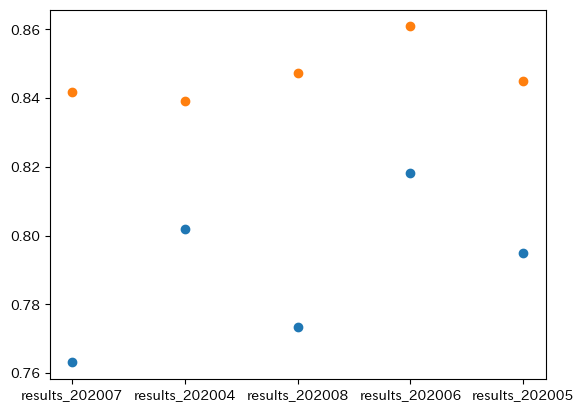

In [ ]:
score_all_gb = score_all.loc[(score_all['model_name']=='GradientBoosting')&(score_all['DataCategory']=='test')]
model_targets = score_all_gb['model_target'].unique()
import matplotlib.pyplot as plt

for model_target in model_targets:
    view_data = score_all_gb.loc[score_all_gb['model_target']==model_target]
    plt.scatter(view_data['dirs'], view_data['acc'])

Trends in model accuracy evaluation results Accuracy increased slightly from April to June, but decreased when the data was learned up to and including July The effect of starting measures in June began to appear in July, so it is possible that the trend has changed slightly. I realized that I can gain various insights by accumulating data while utilizing new data more and more.

#Create a dashboard for a machine learning system

I have acquired a system for skillfully accumulating the data generated each month. I would like to share the trends that emerge from that accumulated data with other so far. In addition, I thought that by creating a dashboard for evaluation and verification of the mechanistic model, I would be able to efficiently conduct ongoing evaluation and verification.

In [ ]:
import os
data_dir = 'data'
input_dir = os.path.join(data_dir, '00_input')
store_monthly_dir = os.path.join(data_dir, '01_store_monthly')
ml_base_dir = os.path.join(data_dir, '02_ml_base')

output_ml_result_dir = os.path.join(data_dir, '10_output_ml_result')
output_report_dir = os.path.join(data_dir, '11_output_report')

master_dir = os.path.join(data_dir, '99_master')
model_dir = 'models'

os.makedirs(input_dir,exist_ok=True)
os.makedirs(store_monthly_dir,exist_ok=True)
os.makedirs(ml_base_dir,exist_ok=True)
os.makedirs(output_ml_result_dir,exist_ok=True)
os.makedirs(output_report_dir,exist_ok=True)
os.makedirs(master_dir,exist_ok=True)
os.makedirs(model_dir,exist_ok=True)

In [ ]:
import os
import pandas as pd
data_dir = 'data'
store_monthly_dir = os.path.join(data_dir, '01_store_monthly')
ml_base_dir = os.path.join(data_dir, '02_ml_base')

output_ml_result_dir = os.path.join(data_dir, '10_output_ml_result')
output_report_dir = os.path.join(data_dir, '11_output_report')

store_monthly_file = 'store_monthly_data.csv'
ml_base_file = 'ml_base_data.csv'

store_monthly_data = pd.read_csv(os.path.join(store_monthly_dir, store_monthly_file),encoding='utf-8')
ml_base_data = pd.read_csv(os.path.join(ml_base_dir, ml_base_file))
display(store_monthly_data.head(3))
display(ml_base_data.head(3))

,store_name,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,order_time_11,order_time_12,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1147,945,202,841,306,844,303,91,122,...,101,95,107,106,100,108,109,96,34.110053,201904
1,さいたま南店,1504,1217,287,1105,399,1104,400,130,135,...,143,142,137,130,113,140,132,155,35.337716,201904
2,さいたま緑店,1028,847,181,756,272,756,272,95,91,...,95,102,82,90,93,95,95,84,34.291617,201904


,store_name,y_weekday,y_weekend,order,order_fin,order_cancel,order_delivery,order_takeout,order_weekday,order_weekend,...,order_time_14,order_time_15,order_time_16,order_time_17,order_time_18,order_time_19,order_time_20,order_time_21,delta_avg,year_month
0,あきる野店,1.0,0.0,1147,945,202,841,306,844,303,...,101,95,107,106,100,108,109,96,34.110053,201904
1,さいたま南店,1.0,1.0,1504,1217,287,1105,399,1104,400,...,143,142,137,130,113,140,132,155,35.337716,201904
2,さいたま緑店,1.0,1.0,1028,847,181,756,272,756,272,...,95,102,82,90,93,95,95,84,34.291617,201904


In [ ]:
ml_results_dirs = os.listdir(output_ml_result_dir)
score_all = []
for ml_results_dir in ml_results_dirs:
    score_file_path = os.path.join(output_ml_result_dir,ml_results_dir, 'score.csv')
    score_monthly = pd.read_csv(score_file_path,encoding='utf-8')
    score_monthly['dirs'] = ml_results_dir
    score_all.append(score_monthly)
score_all = pd.concat(score_all,ignore_index=True)
score_all.head()

,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn,model_name,model_target,dirs
0,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,tree,y_weekday,results_202007
1,test,0.763098,0.791165,0.791165,0.791165,394,104,104,276,tree,y_weekday,results_202007
2,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,RandomForest,y_weekday,results_202007
3,test,0.728929,0.762475,0.767068,0.757937,382,116,122,258,RandomForest,y_weekday,results_202007
4,train,0.828530,0.845714,0.840909,0.850575,962,182,169,734,GradientBoosting,y_weekday,results_202007


In [ ]:
score_all.loc[:,'year_month'] = score_all['dirs'].str.split('_', expand=True)[1]
score_all.head()

,DataCategory,acc,f1,recall,precision,tp,fn,fp,tn,model_name,model_target,dirs,year_month
0,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,tree,y_weekday,results_202007,202007
1,test,0.763098,0.791165,0.791165,0.791165,394,104,104,276,tree,y_weekday,results_202007,202007
2,train,1.000000,1.000000,1.000000,1.000000,1144,0,0,903,RandomForest,y_weekday,results_202007,202007
3,test,0.728929,0.762475,0.767068,0.757937,382,116,122,258,RandomForest,y_weekday,results_202007,202007
4,train,0.828530,0.845714,0.840909,0.850575,962,182,169,734,GradientBoosting,y_weekday,results_202007,202007


In [ ]:
ml_results_dirs = os.listdir(output_ml_result_dir)
importance_all = []
for ml_results_dir in ml_results_dirs:
    importance_file_path = os.path.join(output_ml_result_dir,ml_results_dir, 'importance.csv')
    importance_monthly = pd.read_csv(importance_file_path)
    importance_monthly['dirs'] = ml_results_dir
    importance_all.append(importance_monthly)
importance_all = pd.concat(importance_all,ignore_index=True)
importance_all.loc[:,'year_month'] = importance_all['dirs'].str.split('_', expand=True)[1]
importance_all.head()

,cols,importance,model_name,model_target,dirs,year_month
0,order_weekday,0.323070,tree,y_weekday,results_202007,202007
1,order_weekend,0.303735,tree,y_weekday,results_202007,202007
2,order_delivery,0.032845,tree,y_weekday,results_202007,202007
3,order_time_14,0.027650,tree,y_weekday,results_202007,202007
4,order_fin,0.027326,tree,y_weekday,results_202007,202007


In [ ]:
report_files = os.listdir(output_report_dir)
report_all = []
for report_file in report_files:
    report_file_path = os.path.join(output_report_dir, report_file)
    report_monthly = pd.read_excel(report_file_path)
    report_monthly = report_monthly[['store_name','score_weekday','score_weekend']].copy()
    report_monthly['files'] = report_file
    report_all.append(report_monthly)
report_all = pd.concat(report_all,ignore_index=True)
report_all.head()

,store_name,score_weekday,score_weekend,files
0,あきる野店,0.804468,0.199355,report_pred_202005.xlsx
1,さいたま南店,0.413692,0.127983,report_pred_202005.xlsx
2,さいたま緑店,0.886107,0.410461,report_pred_202005.xlsx
3,さいたま西店,0.525863,0.187360,report_pred_202005.xlsx
4,つくば店,0.745303,0.204626,report_pred_202005.xlsx


In [ ]:
report_all.loc[:,'pred_year_month'] = report_all['files'].str.split('.', expand=True)[0]
report_all.loc[:,'pred_year_month'] = report_all['pred_year_month'].str[12:]
report_all.head()

,store_name,score_weekday,score_weekend,files,pred_year_month
0,あきる野店,0.804468,0.199355,report_pred_202005.xlsx,202005
1,さいたま南店,0.413692,0.127983,report_pred_202005.xlsx,202005
2,さいたま緑店,0.886107,0.410461,report_pred_202005.xlsx,202005
3,さいたま西店,0.525863,0.187360,report_pred_202005.xlsx,202005
4,つくば店,0.745303,0.204626,report_pred_202005.xlsx,202005


In [ ]:
ml_data = ml_base_data[['store_name','y_weekday', 'y_weekend','year_month']].copy()
ml_data.loc[:,'pred_year_month'] = pd.to_datetime(ml_data['year_month'], format='%Y%m')
from dateutil.relativedelta import relativedelta
ml_data.loc[:,'pred_year_month'] = ml_data['pred_year_month'].map(lambda x: x + relativedelta(months=1))
ml_data.loc[:,'pred_year_month'] = ml_data['pred_year_month'].dt.strftime('%Y%m')
del ml_data['year_month']
ml_data.head(3)

<ipython-input-57-739e980efa47>:4: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  ml_data.loc[:,'pred_year_month'] = ml_data['pred_year_month'].map(lambda x: x + relativedelta(months=1))


,store_name,y_weekday,y_weekend,pred_year_month
0,あきる野店,1.0,0.0,201905
1,さいたま南店,1.0,1.0,201905
2,さいたま緑店,1.0,1.0,201905


In [ ]:
report_valid = pd.merge(report_all, ml_data, on=['store_name','pred_year_month'], how='left')
report_valid

,store_name,score_weekday,score_weekend,files,pred_year_month,y_weekday,y_weekend
0,あきる野店,0.804468,0.199355,report_pred_202005.xlsx,202005,0.0,1.0
1,さいたま南店,0.413692,0.127983,report_pred_202005.xlsx,202005,0.0,1.0
2,さいたま緑店,0.886107,0.410461,report_pred_202005.xlsx,202005,0.0,1.0
3,さいたま西店,0.525863,0.187360,report_pred_202005.xlsx,202005,0.0,1.0
4,つくば店,0.745303,0.204626,report_pred_202005.xlsx,202005,0.0,1.0
...,...,...,...,...,...,...,...
190,高津店,0.604720,0.258655,report_pred_202005.xlsx,202005,0.0,1.0
191,高田馬場店,0.777813,0.282977,report_pred_202005.xlsx,202005,0.0,1.0
192,鴻巣店,0.498269,0.270865,report_pred_202005.xlsx,202005,0.0,1.0
193,鶴見店,0.765105,0.189014,report_pred_202005.xlsx,202005,0.0,1.0


In [ ]:
report_valid.dropna(inplace=True)
report_valid

,store_name,score_weekday,score_weekend,files,pred_year_month,y_weekday,y_weekend
0,あきる野店,0.804468,0.199355,report_pred_202005.xlsx,202005,0.0,1.0
1,さいたま南店,0.413692,0.127983,report_pred_202005.xlsx,202005,0.0,1.0
2,さいたま緑店,0.886107,0.410461,report_pred_202005.xlsx,202005,0.0,1.0
3,さいたま西店,0.525863,0.187360,report_pred_202005.xlsx,202005,0.0,1.0
4,つくば店,0.745303,0.204626,report_pred_202005.xlsx,202005,0.0,1.0
...,...,...,...,...,...,...,...
190,高津店,0.604720,0.258655,report_pred_202005.xlsx,202005,0.0,1.0
191,高田馬場店,0.777813,0.282977,report_pred_202005.xlsx,202005,0.0,1.0
192,鴻巣店,0.498269,0.270865,report_pred_202005.xlsx,202005,0.0,1.0
193,鶴見店,0.765105,0.189014,report_pred_202005.xlsx,202005,0.0,1.0


SelectMultiple(index=(0,), options=('あきる野店', 'さいたま南店', 'さいたま緑店', 'さいたま西店', 'つくば店', '三浦店', '三鷹店', '上尾店', '上野店',…

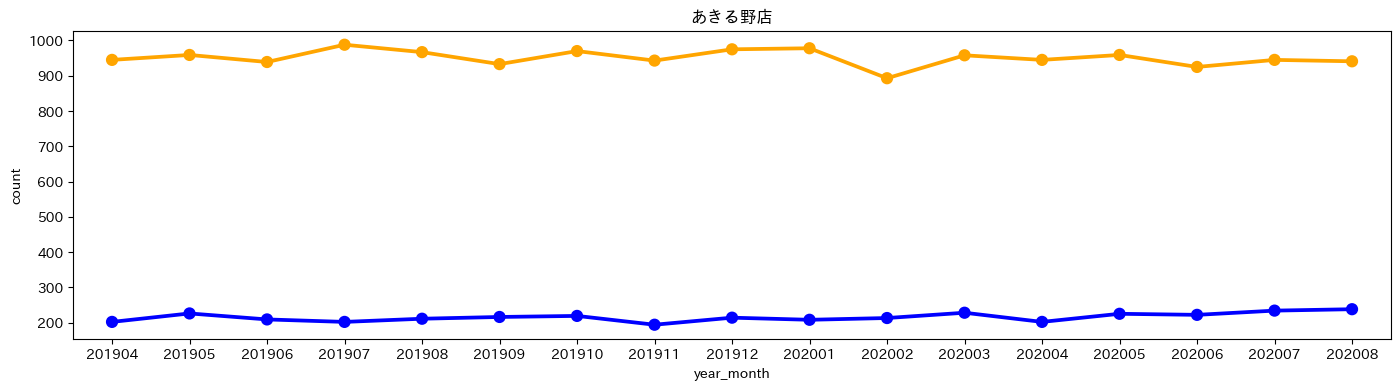

In [ ]:
import seaborn as sns
from IPython.display import display, clear_output
from ipywidgets import Select, SelectMultiple
import matplotlib.pyplot as plt
import japanize_matplotlib

store_list = store_monthly_data['store_name'].unique()

def make_graph_96(val):
    clear_output()
    display(select_96)
    
    fig = plt.figure(figsize=(17,4))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)
    
    for i, trg in enumerate(val['new']):
        pick_data = store_monthly_data.loc[store_monthly_data['store_name']==trg]
        graph_fin = pick_data[['store_name','order_fin', 'year_month']].copy()
        graph_fin.loc[:,'type'] = 'fin'
        graph_fin = graph_fin.rename(columns={'order_fin': 'count'})
                         
        graph_cancel = pick_data[['store_name','order_cancel', 'year_month']].copy()
        graph_cancel.loc[:,'type'] = 'cancel'
        graph_cancel = graph_cancel.rename(columns={'order_cancel': 'count'})
                         
        ax = fig.add_subplot(1, len(val['new']), (i+1))
        sns.pointplot(x="year_month", y="count", data=graph_fin, color='orange')
        sns.pointplot(x="year_month", y="count", data=graph_cancel, color='blue')
        ax.set_title(trg)
        
    
select_96 = SelectMultiple(options=store_list)
select_96.observe(make_graph_96, names='value')
display(select_96)

Select(index=2, options=('tree', 'RandomForest', 'GradientBoosting'), value='GradientBoosting')

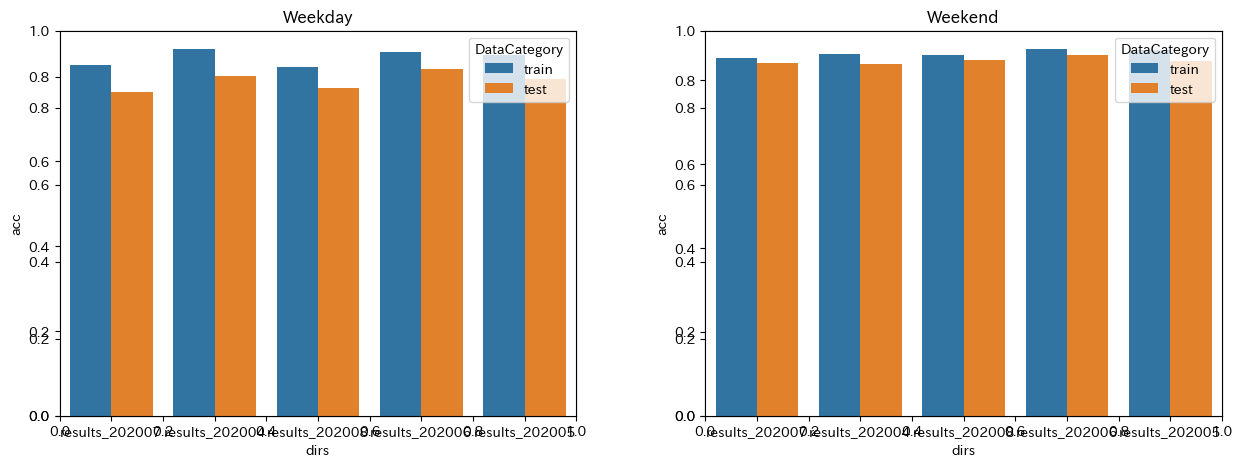

In [ ]:
opt1 = ''

def s1_update_97(val):
    global opt1
    opt1 = val['new']
    graph_97()
    
def graph_97():
    clear_output()
    display(select1_97)
    
    graph_df_wd = score_all.loc[(score_all['model_name']==opt1)&(score_all['model_target']=='y_weekday')].copy()
    graph_df_we = score_all.loc[(score_all['model_name']==opt1)&(score_all['model_target']=='y_weekend')].copy()
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)
    ax1 = fig.add_subplot(1, 2, 1)
    sns.barplot(x='dirs', y='acc', data=graph_df_wd, hue='DataCategory')
    ax1.set_title('Weekday')
    
    ax2 = fig.add_subplot(1, 2, 2)
    sns.barplot(x='dirs', y='acc', data=graph_df_we, hue='DataCategory')
    ax2.set_title('Weekend')
    

s1_option_97 = score_all['model_name'].unique()

select1_97 = Select(options=s1_option_97)
select1_97.observe(s1_update_97, names='value')

display(select1_97)

Select(index=2, options=('tree', 'RandomForest', 'GradientBoosting'), value='GradientBoosting')

Select(index=1, options=('y_weekday', 'y_weekend'), value='y_weekend')

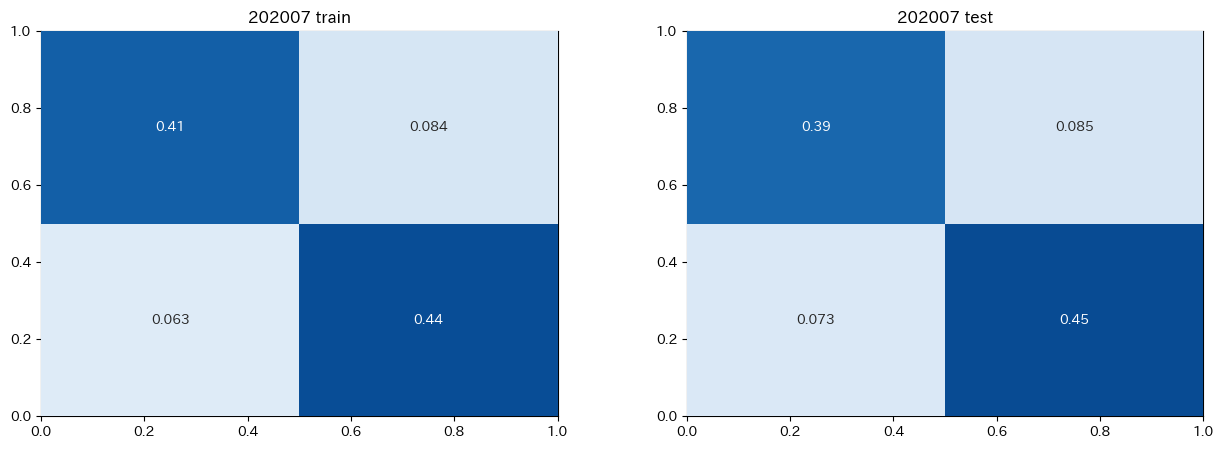

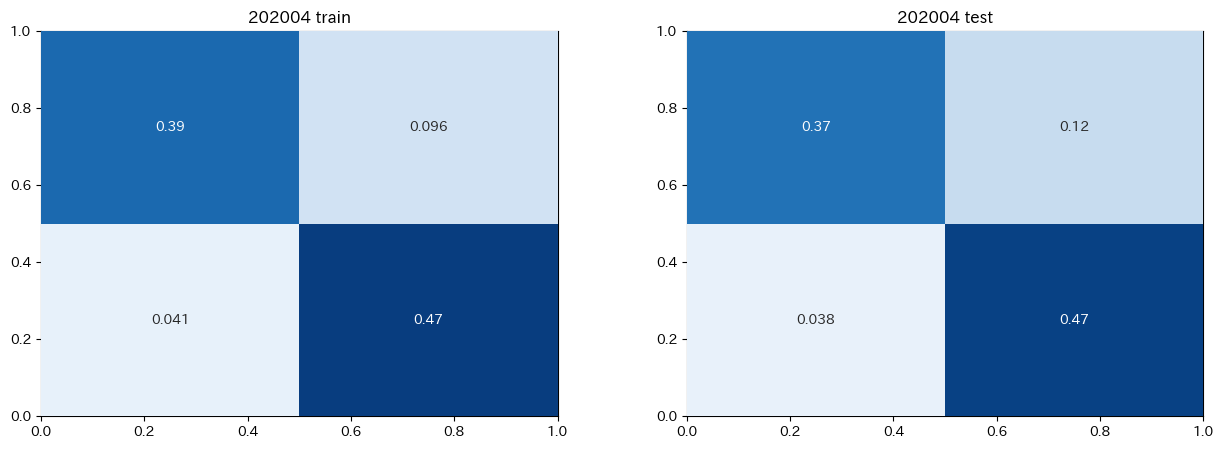

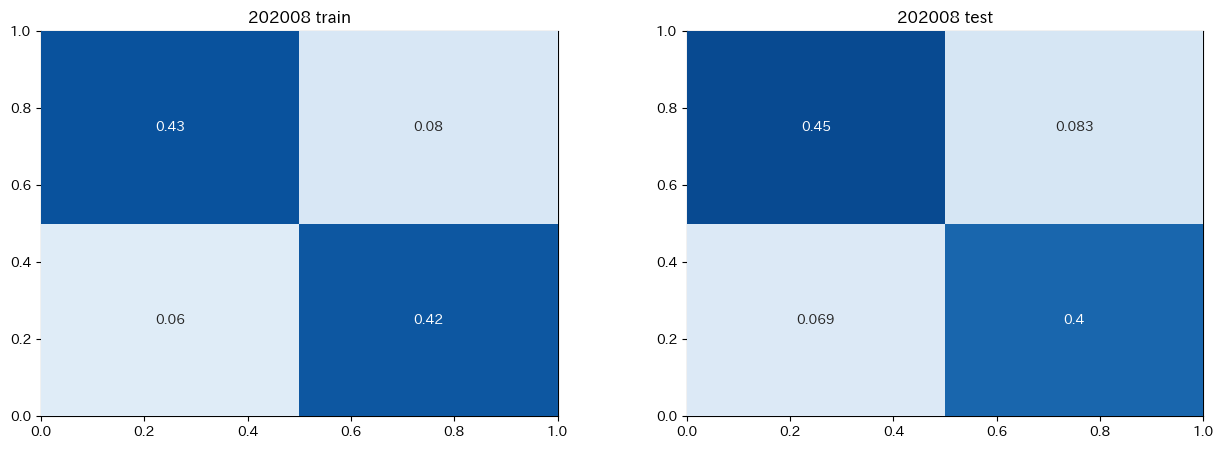

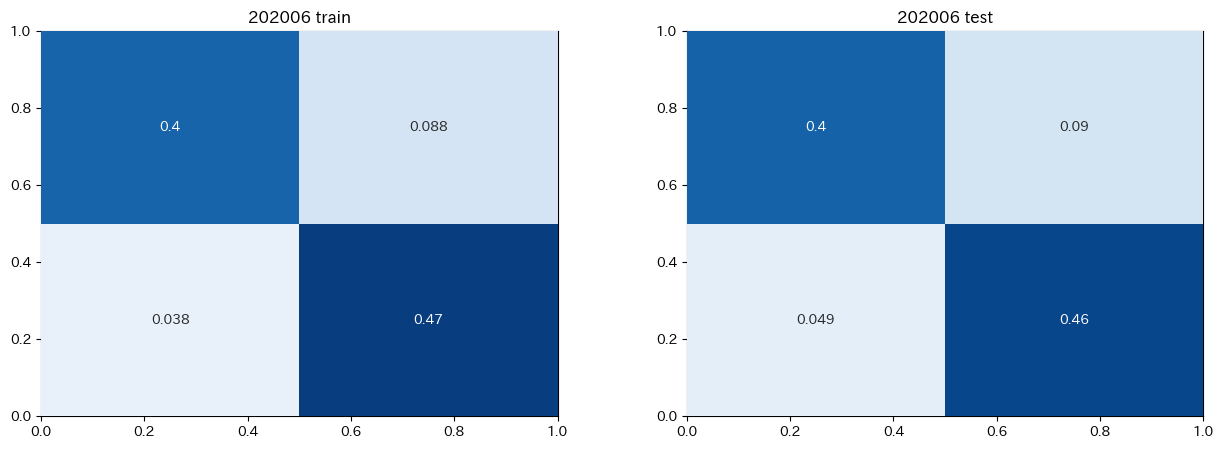

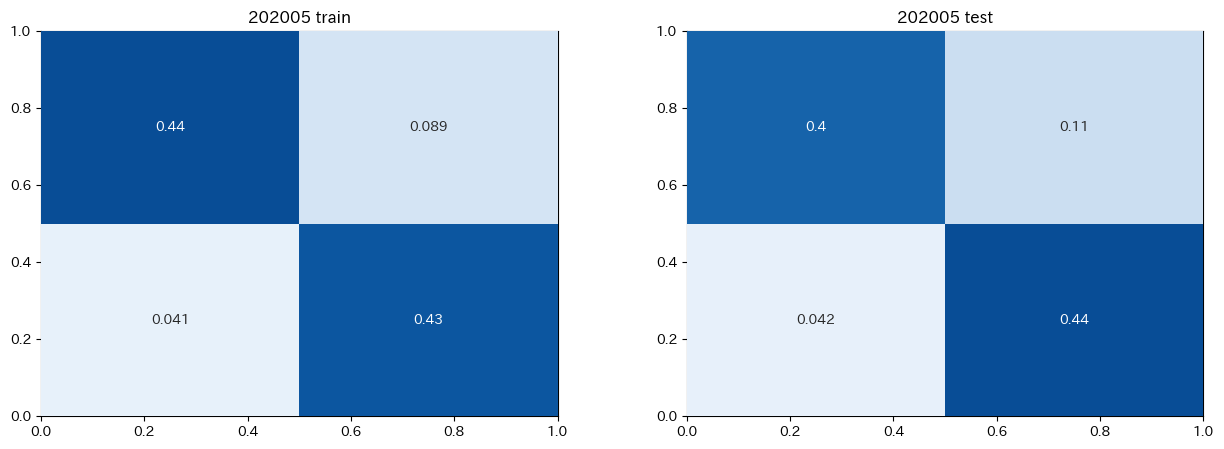

In [ ]:
opt1 = ''
opt2 = ''

def s1_update_98(val):
    global opt1
    opt1 = val['new']
    graph_98()

def s2_update_98(val):
    global opt2
    opt2 = val['new']
    graph_98()
       
def graph_98():
    clear_output()
    display(select1_98, select2_98)
    
    for i, ym in enumerate(score_all['year_month'].unique()):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
        plt.subplots_adjust(wspace=0.25, hspace=0.6)
    
        tmp = score_all.loc[(score_all['model_name']==opt1) & (score_all['model_target']==opt2) &
                            (score_all['DataCategory']=='train') & (score_all['year_month']==ym)]
        if len(tmp) == 1:
            maxcnt = tmp["tp"].values[0] + tmp["fn"].values[0] + tmp["fp"].values[0] + tmp["tn"].values[0]
            cm = [[tmp['tp'].values[0]/maxcnt, tmp['fn'].values[0]/maxcnt], [tmp['fp'].values[0]/maxcnt, tmp['tn'].values[0]/maxcnt]]
            ax1 = fig.add_subplot(1, 2, 1)
            sns.heatmap(cm, vmax=0.5, vmin=0, cmap='Blues', annot=True, xticklabels=False, yticklabels=False, cbar=False)
            ax1.set_title(f'{ym} train')

        tmp = score_all.loc[(score_all['model_name']==opt1) & (score_all['model_target']==opt2) &
                            (score_all['DataCategory']=='test') & (score_all['year_month']==ym)]
        if len(tmp) == 1:
            maxcnt = tmp["tp"].values[0] + tmp["fn"].values[0] + tmp["fp"].values[0] + tmp["tn"].values[0]
            cm = [[tmp['tp'].values[0]/maxcnt, tmp['fn'].values[0]/maxcnt], [tmp['fp'].values[0]/maxcnt, tmp['tn'].values[0]/maxcnt]]
            ax2 = fig.add_subplot(1, 2, 2)
            sns.heatmap(cm, vmax=0.5, vmin=0, cmap='Blues', annot=True, xticklabels=False, yticklabels=False, cbar=False)
            ax2.set_title(f'{ym} test')
        

s1_option_98 = score_all['model_name'].unique()
s2_option_98 = score_all['model_target'].unique()

select1_98 = Select(options=s1_option_98)
select1_98.observe(s1_update_98, names='value')

select2_98 = Select(options=s2_option_98)
select2_98.observe(s2_update_98, names='value')

display(select1_98, select2_98)

Select(index=2, options=('tree', 'RandomForest', 'GradientBoosting'), value='GradientBoosting')

Select(index=3, options=('202007', '202004', '202008', '202006', '202005'), value='202006')

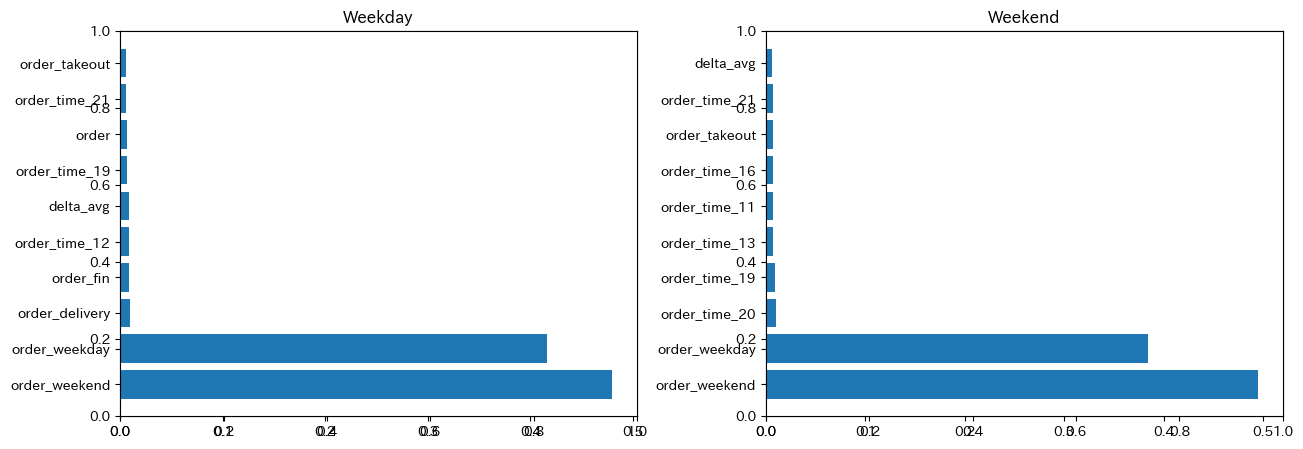

In [ ]:
opt1 = ''
opt2 = ''

def s1_update(val):
    global opt1
    opt1 = val['new']
    if opt2 != '':
        graph_by_multi()
    
def s2_update(val):
    global opt2
    opt2 = val['new']
    if opt1 != '':
        graph_by_multi()
    
def graph_by_multi():
    clear_output()
    display(select1, select2)
    
    importance_tg_wd = importance_all.loc[(importance_all['model_name']==opt1)&
                                    (importance_all['year_month']==opt2)&
                                    (importance_all['model_target']=='y_weekday')].copy()
    
    importance_tg_we = importance_all.loc[(importance_all['model_name']==opt1)&
                                    (importance_all['year_month']==opt2)&
                                    (importance_all['model_target']=='y_weekend')].copy()
    
    importance_tg_wd.sort_values('importance',ascending=False,inplace=True)
    importance_tg_we.sort_values('importance',ascending=False,inplace=True)
    
    importance_tg_wd = importance_tg_wd.head(10)
    importance_tg_we = importance_tg_we.head(10)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    plt.subplots_adjust(wspace=0.25, hspace=0.6)
    ax1 = fig.add_subplot(1, 2, 1)
    plt.barh(importance_tg_wd['cols'], importance_tg_wd['importance'])
    ax1.set_title('Weekday')
    
    ax2 = fig.add_subplot(1, 2, 2)
    plt.barh(importance_tg_we['cols'], importance_tg_we['importance'])
    ax2.set_title('Weekend')


s1_option = importance_all['model_name'].unique()
s2_option = importance_all['year_month'].unique()

select1 = Select(options=s1_option)
select1.observe(s1_update, names='value')

select2 = Select(options=s2_option)
select2.observe(s2_update, names='value')

display(select1, select2)

<ipython-input-64-ef9b29cb5944>:8: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  view_data = view_data.groupby('pred_year_month').sum()[['correct_weekday','correct_weekend', 'count']]


<Axes: xlabel='pred_year_month'>

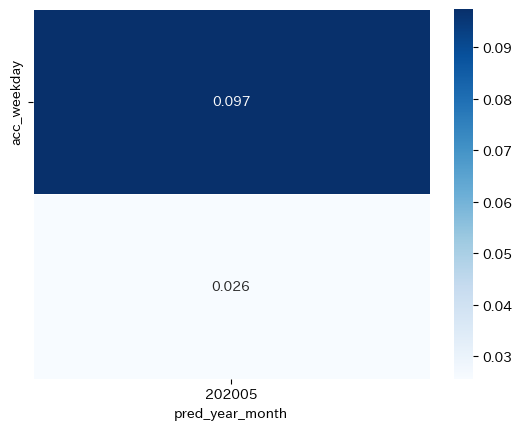

In [ ]:
view_data = report_valid.copy()
view_data.loc[(view_data['score_weekday'] >= 0.5)&(view_data['y_weekday'] ==1), 'correct_weekday'] = 1
view_data.loc[(view_data['score_weekday'] < 0.5)&(view_data['y_weekday'] ==0), 'correct_weekday'] = 1
view_data.loc[(view_data['score_weekend'] >= 0.5)&(view_data['y_weekend'] ==1), 'correct_weekend'] = 1
view_data.loc[(view_data['score_weekend'] < 0.5)&(view_data['y_weekend'] ==0), 'correct_weekend'] = 1
view_data.loc[:,'count'] = 1
view_data.fillna(0, inplace=True)
view_data = view_data.groupby('pred_year_month').sum()[['correct_weekday','correct_weekend', 'count']]
view_data.loc[:, 'acc_weekday'] = view_data['correct_weekday'] / view_data['count']
view_data.loc[:, 'acc_weekend'] = view_data['correct_weekend'] / view_data['count']
view_data = view_data[['acc_weekday','acc_weekend']]

sns.heatmap(view_data.T, cmap='Blues', annot=True, yticklabels=2, linewidths=.5)

The accuracy of our model was significantly diminished in July, indicating a potential shortfall in its ability to manage time-series data. Improving the model's capacity to handle time-dependent data could be a promising area for enhancement.

Additionally, the division of training and test data currently lacks consideration for temporal patterns, with data randomly segmented rather than being stratified by time. To enhance model robustness, it would be advantageous to implement a mechanism for continuous validation. This approach, focused on rapidly cycling through the Plan, Do, Check, Act (PDCA) process, would provide more immediate feedback and facilitate quicker iterative improvements to the model.